In [ ]:
!pip install imblearn
!pip install mlflow

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    auc,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    make_scorer,
    classification_report
)

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Préparation des données

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/P7/df_sample')


In [ ]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

# Utilisation du meilleur modèle trouvé pour la prédiction

In [ ]:
# définir la fonction personnalisé
def cost_f(y, y_pred):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  return fp + 10 * fn
# transformer en scorer
cost_s = make_scorer(cost_f, greater_is_better= False)

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
import mlflow
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

mlflow.set_experiment('RandomForestClassifier')

with mlflow.start_run(run_name ='param_grid_best_model',  nested=True):

  pipe_rf = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('oversampling', SMOTE(sampling_strategy='auto')),
    ('rf',RandomForestClassifier(class_weight= 'balanced',
                                  min_samples_split= 600,
                                  n_estimators= 100))
])

  start_fit_time = time.time()
  pipe_rf.fit(X, y)
  fit_duration = time.time() - start_fit_time

  y_pred =( pipe_rf.predict_proba(X,)[:,1]>= 0.4).astype('int')

  acc = accuracy_score(y, y_pred)
  cout = cost_f(y,y_pred)
  mlflow.log_param("Threshold", 0.3)
  mlflow.log_metric("Accuracy", acc)
  mlflow.log_metric("Business Score", cout)

  #Enregistrer les temps dans mlflow
  mlflow.log_metric("Fit Time", fit_duration)
  mlflow.end_run()


**Classification Report**

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.87     28153
           1       0.19      0.57      0.29      2443

    accuracy                           0.77     30596
   macro avg       0.57      0.68      0.58     30596
weighted avg       0.89      0.77      0.82     30596



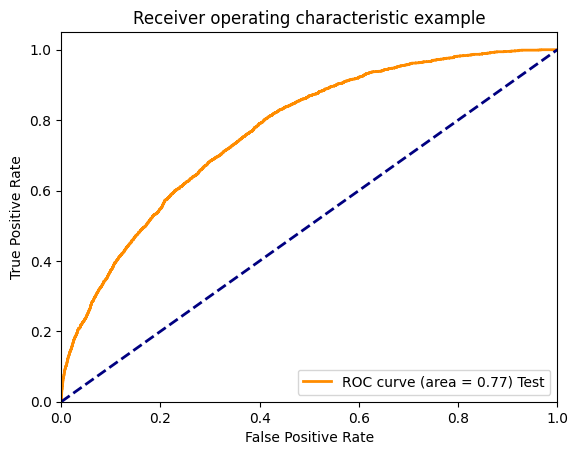

In [ ]:
# Courbe ROC pour le jeu de données test
# Courbe ROC
y_prob = pipe_rf.predict_proba(X,)[:,1]

fpr, tpr ,_= roc_curve(y, y_prob)

roc_auc = auc(fpr, tpr)


# Affichage des courbes ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) Test' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('mon business score est ',cout, 'pour une accuracy de ',acc)

mon business score est  16383 pour une accuracy de  0.7736959079618251


# Interprétabilité:
## Interprétabilité globale : Importance des caractéristiques (Features importance)


In [ ]:
pipe_rf[2]

RandomForestClassifier(class_weight='balanced', min_samples_split=600)

In [ ]:
importance =pipe_rf[2].feature_importances_
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00883
Feature: 1, Score: 0.00042
Feature: 2, Score: 0.00462
Feature: 3, Score: 0.00294
Feature: 4, Score: 0.00022
Feature: 5, Score: 0.00052
Feature: 6, Score: 0.00312
Feature: 7, Score: 0.02341
Feature: 8, Score: 0.00372
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00788
Feature: 11, Score: 0.00210
Feature: 12, Score: 0.00238
Feature: 13, Score: 0.02839
Feature: 14, Score: 0.00409
Feature: 15, Score: 0.01606
Feature: 16, Score: 0.01569
Feature: 17, Score: 0.00245
Feature: 18, Score: 0.01444
Feature: 19, Score: 0.00528
Feature: 20, Score: 0.00015
Feature: 21, Score: 0.07307
Feature: 22, Score: 0.00659
Feature: 23, Score: 0.01429
Feature: 24, Score: 0.00025
Feature: 25, Score: 0.00022
Feature: 26, Score: 0.00649
Feature: 27, Score: 0.00245
Feature: 28, Score: 0.00005
Feature: 29, Score: 0.00042
Feature: 30, Score: 0.00810
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00002
Feature: 33, Score: 0.00035
Feature: 34, Score: 0.00194
Feature: 35, Score: 0.00024
Fe

Text(0.5, 0, 'Random Forest Feature Importance')

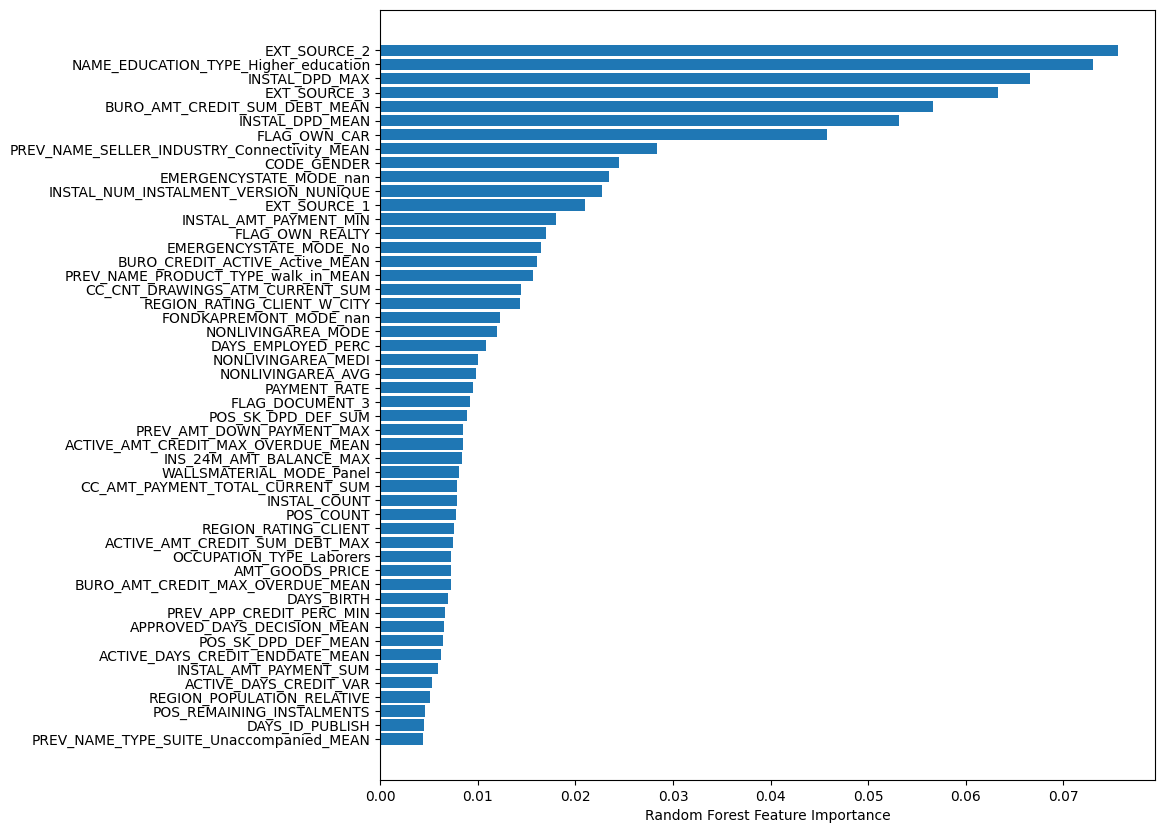

In [ ]:
sorted_idx =importance.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X.columns[sorted_idx][-50:], importance[sorted_idx][-50:])
plt.xlabel("Random Forest Feature Importance")

**SHAP (SHapley Additive explanations)** :
**Graphique SHAP résumé pour l'interprétabilité globale**

In [ ]:
shap.initjs()

In [ ]:
import shap

explainer = shap.TreeExplainer(pipe_rf[2])
shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
shap_values.shape

(30596, 159, 2)

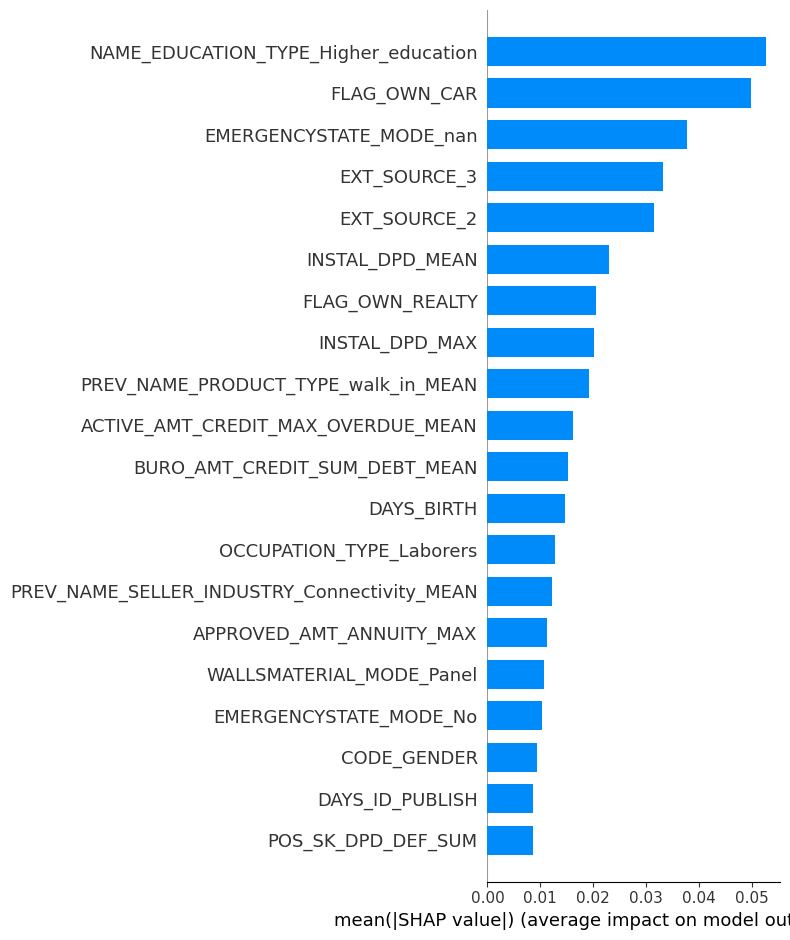

In [ ]:
shap.summary_plot(shap_values[:,:,1], X, plot_type="bar")

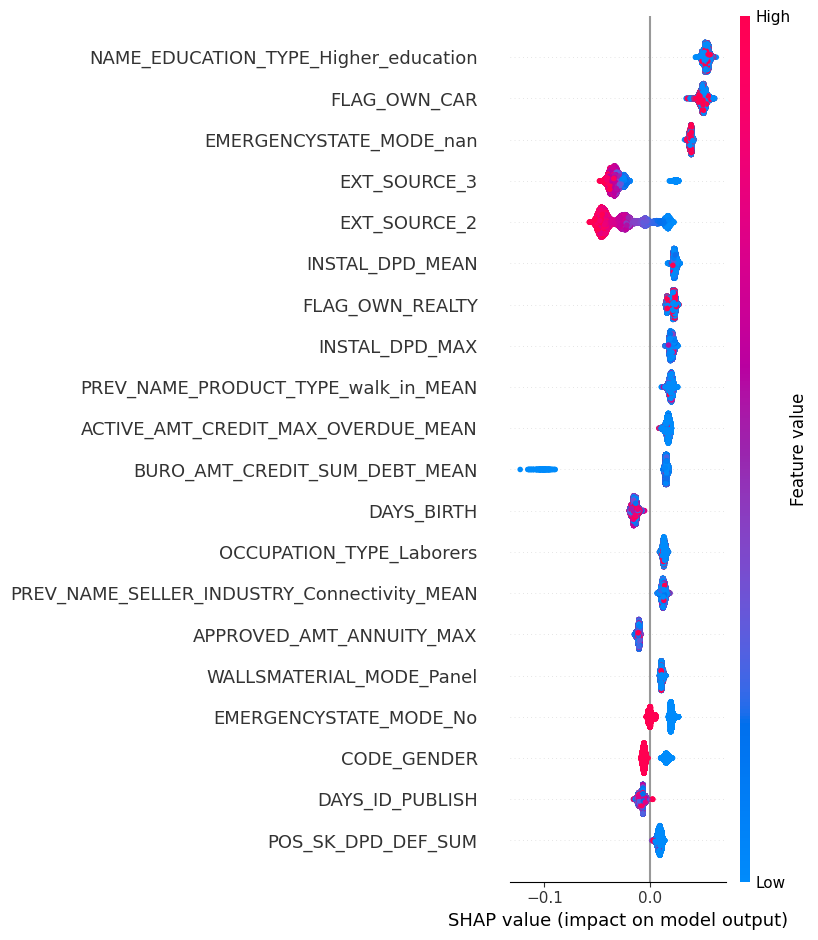

In [ ]:
shap.summary_plot(shap_values[:,:,1], X)

**Interprétabilité Locale**